# 04 - Exploring MHD files, part 2

Welcome to Part 2 of the MHD file Exploration. So far, we have analyzed a single random UID and explored it a little bit. We still have not searched for nodules, but are only getting ourselves familiar with some of the data structures that we will deal with.

With the knowledge acquired from the previous step, we will give Dask a spin. In this notebook, we will try to:
- Calculate the distribution of all values in all CT scans, generating (hopefully) a histogram
- Try to find if there are any NaN values
- Try to extract summary statistics, that represents the total of our data

> Attention!! Running this notebook could take minutes/hours/days depending on your hardware. Proceed with caution.

To do so, we will first start with imports and setting the appropriate variables:

In [1]:
from LUNA16.utils.analyze_folders import analyze_folder
from LUNA16.utils.analyze_data_distribution import read_mhd
import matplotlib.pyplot as plt
import random
import dask
import dask.array as da
import numpy as np
from dask.distributed import Client
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 8]
random.seed(123)

In [2]:
ROOT_FOLDER = "/home/azureuser/cloudfiles/data/LUNA16/extracted"
all_files = analyze_folder(ROOT_FOLDER)
assert len(all_files) == 3567
all_mhd_files = [file for file in all_files if file.extension == "mhd"]
assert len(all_mhd_files) == 1776

In [3]:
%%time
lazy_array = [dask.delayed(read_mhd)(x) for x in all_mhd_files]
print(len(lazy_array), type(lazy_array))

1776 <class 'list'>
CPU times: user 65.2 ms, sys: 20.5 ms, total: 85.7 ms
Wall time: 85.1 ms


One thing that I would like to call out is that `da.from_delayed` expects a `shape` attribute. The problem with this function is that the size of each CT scan MHD file is different - as we have noticed in the earlier notebook, the first dimension of each CT scan varied. To overcome this problem, I have tried setting the first dimension of the shape to `np.nan` which worked perfectly when concatenating the arrays and computing them for further operations.

In [4]:
%%time
lazy_array = [da.from_delayed(x, shape=(np.nan, 512, 512), dtype=np.float32) for x in lazy_array]
print(len(lazy_array), type(lazy_array))

1776 <class 'list'>
CPU times: user 146 ms, sys: 867 µs, total: 147 ms
Wall time: 146 ms


In [5]:
lazy_array[0:5]

[dask.array<from-value, shape=(nan, 512, 512), dtype=float32, chunksize=(nan, 512, 512), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(nan, 512, 512), dtype=float32, chunksize=(nan, 512, 512), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(nan, 512, 512), dtype=float32, chunksize=(nan, 512, 512), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(nan, 512, 512), dtype=float32, chunksize=(nan, 512, 512), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(nan, 512, 512), dtype=float32, chunksize=(nan, 512, 512), chunktype=numpy.ndarray>]

In [6]:
%%time
big_array = da.concatenate(lazy_array, axis=0)

CPU times: user 164 ms, sys: 247 µs, total: 165 ms
Wall time: 173 ms


In [7]:
big_array

dask.array<concatenate, shape=(nan, 512, 512), dtype=float32, chunksize=(nan, 512, 512), chunktype=numpy.ndarray>

Out of curiosity, let's try to print out the shape of the `big_array` object. This should be the total array of all CT scans, concatenated across the 0 axis. Let's have a look:

In [15]:
%%time
array_size = big_array.compute_chunk_sizes().shape
print(array_size)

(454450, 512, 512)
CPU times: user 5min 9s, sys: 3min 33s, total: 8min 43s
Wall time: 3min 33s


Let's try to find out if our data has any `NaN` values in it.

In [18]:
%%time
nans = da.isnan(big_array).sum().compute()
print(f"NaNs found: {nans}")

NaNs found :0
CPU times: user 7min 3s, sys: 3min 41s, total: 10min 44s
Wall time: 4min 37s


We have no `NaNs` in our dataset, and this is great!! We can now put our attention to building a histogram of all the values in the file(s). To do so, we will ultimately be relying on `da.array.histogram()`, but that function will require us to provide a minimum and maximum value. Therefore, we will search for these values now.

In [16]:
%%time
max_value = big_array.max().compute()
print(f"the Biggest value in the dataset is: {max_value}")

the Biggest value in the dataset is: 32767.0
CPU times: user 5min 41s, sys: 3min 33s, total: 9min 15s
Wall time: 4min 40s


In [19]:
%%time
min_value = big_array.min().compute()
print(f"the Smallest value in the dataset is: {min_value}")

the Smallest value in the dataset is: -32768.0
CPU times: user 5min 43s, sys: 3min 25s, total: 9min 8s
Wall time: 4min 42s


In [23]:
%%time
hist_computation, bins = da.histogram(big_array, bins=1000, range=[min_value, max_value])
hist_computation = hist_computation.compute()

CPU times: user 1h 6min 32s, sys: 3min 7s, total: 1h 9min 39s
Wall time: 9min 54s


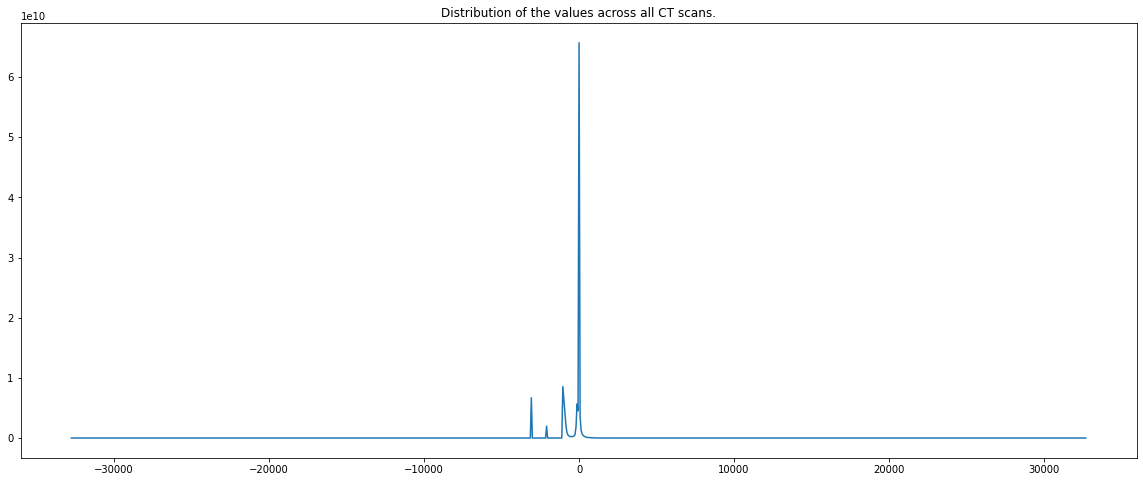

In [30]:
plt.plot(bins[:-1], hist_computation)
plt.title("Distribution of the values across all CT scans.")
plt.show()

We can see that picking these extreme values of min/max are not very usefull for our purpose. Instead, we will use the previously gathered information (-3000, 3000) from the previous notebook. There is almost nothing happening at those edge cases.

In [31]:
%%time
hist_computation2, bins2 = da.histogram(big_array, bins=1000, range=[-3000, 3000])
hist_computation2 = hist_computation2.compute()

CPU times: user 1h 6min 39s, sys: 3min 8s, total: 1h 9min 48s
Wall time: 9min 58s


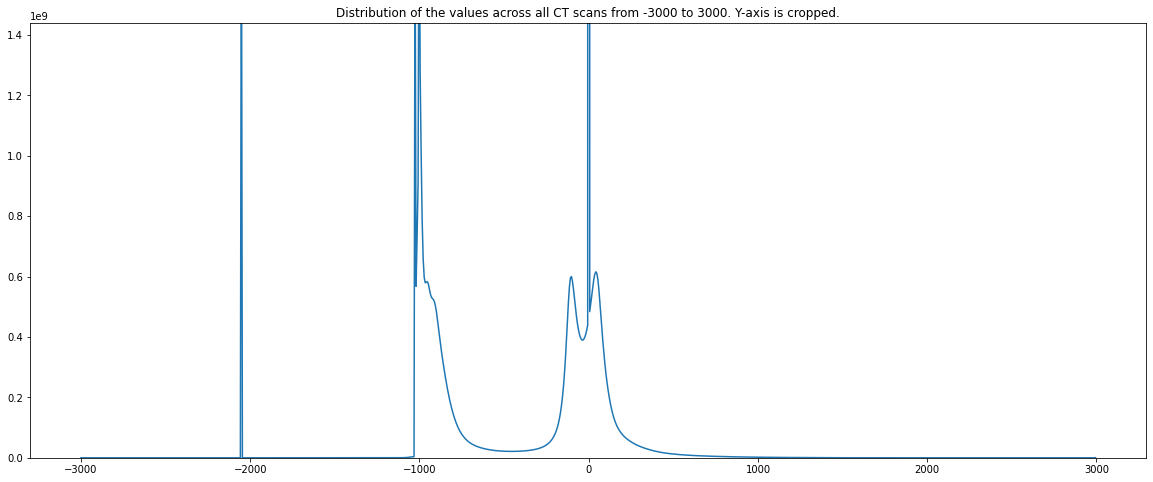

In [66]:
plt.interactive(True)
plt.plot (bins2[:-1], hist_computation2)

plt.ylim([0, 1440000000])
plt.title("Distribution of the values across all CT scans from -3000 to 3000. Y-axis is cropped.")
plt.show()

## Conclusion

This concludes this notebook. We havent discovered anything of extreme high importance, except some key take-aways:

- We've learnt how to use `dask` to manipulate massive data on a single machine, and that's amazing :)
- There are no `NaNs` in our data.
- Most of the data seems to be living near the 0 value, and nothing much happens at the extremes values.
- It seems that we should clip the data to [-1000, 1000], as it seems there is nothing of importance outside these values. Maybe before closing this notebook, we should count how many values do we have that fall out of this range?

In [12]:
%%time
less_than_minus_1000 = da.sum(big_array <= -1000).compute()
print(f"The number of Voxels that have values less than -1000 are: {less_than_minus_1000}")

The number of Voxels that have values less than -1000 are: 14129077501
CPU times: user 7min 4s, sys: 3min 21s, total: 10min 26s
Wall time: 4min 25s


In [13]:
%%time
more_than_1000 = da.sum(big_array >= 1000).compute()
print(f"The number of Voxels that have values less than -1000 are: {more_than_1000}")

The number of Voxels that have values less than -1000 are: 83705365
CPU times: user 7min 2s, sys: 3min 26s, total: 10min 29s
Wall time: 4min 38s


In [21]:
array_size_flat = np.prod([x for x in array_size])

In [22]:
print(f"{less_than_minus_1000 / array_size_flat} - {more_than_1000 / array_size_flat}")

0.11860084345663639 - 0.0007026309318597042


Interesting!!! it turns out that 11.86% of the cells in the CT scans have values lower than -1000, but there is only 0.07% cells that contain the high values above 1000.